<a href="https://github.com/theonaunheim">
    <img style="border-radius: 100%; float: right;" src="static/strawberry_thief_square.png" width=10% alt="Theo Naunheim's Github">
</a>

<br style="clear: both">
<hr>
<br>
<h1 align='center'>Preprocessing</h1>

<br>

<div style="display: table; width: 100%">
    <div style="display: table-row; width: 100%;">
        <div style="display: table-cell; width: 50%; vertical-align: middle;">
            <img src="static/log_transform.svg" width="200">
        </div>
        <div style="display: table-cell; width: 10%">
        </div>
        <div style="display: table-cell; width: 40%; vertical-align: top;">
            <blockquote>
                <p style="font-style: italic;">"Give me six hours to chop down a tree and I will spend the first four sharpening the axe."</p>
                <br>
                <p>-Abraham Lincoln</p>
            </blockquote>
        </div>
    </div>
</div>

<br>

<div align='left'>
    Image courtesy of <a href='https://commons.wikimedia.org/wiki/File:Population_vs_area.svg'>Skbkekas</a> under the <a href='https://creativecommons.org/licenses/by-sa/3.0/deed.en'>CC BY-SA 3.0</a>
</div>

<hr>

In [1]:
# Import all the things.
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import warnings

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Generally

Good data will beat good algorithms 9 times out of 10. ML algorithms are finicky beasts, and if you do not adequately clean and prepare your data your results will be garbage. In this section, we're going to run through some of the more useful data processing operations and also take some detours into related data concepts.

Outside of the pandas library, most of our preprocessing will come from the following modules:

* [sklearn.preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
* [sklearn.model_selection](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [sklearn.feature_selection](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)
* [sklearn.feature_extraction](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction)
* [sklearn.decomposition](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition)


For additional detail on cleaning data, see the "Automation and Cleaning Data in Python" presentation.

---

## Train test split

Though it's more of a model validation strategy, [train test splits](https://en.wikipedia.org/wiki/Training,_test,_and_validation_sets) are done prior to model creation which is why we will address them here.

* [Train Test Split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

As mentioned in the last section, we **train** our algorithm using data prior predicting with it. We can then **test** the predictive power of our model (i.e. how good or bad it is at a particular job) by validating or analyzing its results. The data you use for training and testing should be separate--otherwise your model will be able to perfectly score what it has seen, but won't be able to predict anything useful for unseen data. This is known as **[overfitting](https://en.wikipedia.org/wiki/Overfitting)**.

In other words, you take a large portion of your data, and use it to train your model. You then use the remaining data to test on. Obviously this means that you are taking away training data from your model, which can lead to inferior results. We will discuss cross-validation as a strategy to mitigate this issue in the validation notebook.

For an excellent demo, see [Scikit: Underfitting vs. Overfitting](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)

### If you learn nothing else, learn that you should always segregate your training and testing data.

Note: I generally leave the train test split ratio at .25, but [opinions differ on the optimal split](https://stats.stackexchange.com/questions/113994/how-to-choose-the-training-cross-validation-and-test-set-sizes-for-small-sampl).

#### So what's the best way to split into testing and training sets?

In [2]:
# Load dataset
df = pd.read_csv('data/othello.csv', index_col=0)

# How to split randomly split a dataset in one line
X_train, X_test, y_train, y_test = train_test_split(df['experience'], df['salary'], test_size=.2)

print('Train X')
print(X_train)
print()

print('Train y')
print(y_train)
print()

print('Orig df')
print(df['experience'])

Train X
Iago          5
Cassio        0
Desdemona    15
Bianca       10
Name: experience, dtype: int64

Train y
Iago          66600
Cassio        60000
Desdemona    210000
Bianca        80000
Name: salary, dtype: int64

Orig df
Cassio        0
Iago          5
Bianca       10
Desdemona    15
Othello      20
Name: experience, dtype: int64


---

## Normalization

Whether you see it or not, machine learning algorithms work entirely in the realm of numbers. Many machine learning algorithms (i.e. all of them except for decision trees) need to be given "scaled" values. This is referred to as ["feature scaling" or "normalization"](https://en.wikipedia.org/wiki/Feature_scaling). If algorithms aren't given scaled features, they are likely to give you garbage because they will attribute extra importance to the larger values.

We generally do this via [Z-scores](https://en.wikipedia.org/wiki/Standard_score) and outlier removal. Your workhorses here will be the StandardScaler and RobustScaler. These are largely the same, but the RobustScaler has better support for outlier smoothing.

* [RobustScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)
* [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [3]:
# Create our scalers.
rs = RobustScaler()
ss = StandardScaler()

# This needs to be fitted and transformed as it is used to convert.
print(rs.fit_transform(df))

# rs.fit_transform(df) is the same as:
# rs.fit(df)
# rs.transform(df)

# Display nicely.
pd.DataFrame(
    np.concatenate([
        df.values,
        rs.fit_transform(df),
        ss.fit_transform(df)
    ], axis=1),
    index=df.index,
    columns=[
        'experience',
        'salary',
        'robust_experience_z',
        'robust_salary_z',
        'standard_experience_z',
        'standard_salary_z'
    ]
)

[[-1.         -0.13947001]
 [-0.5        -0.09344491]
 [ 0.          0.        ]
 [ 0.5         0.90655509]
 [ 1.          1.53417015]]


,experience,salary,robust_experience_z,robust_salary_z,standard_experience_z,standard_salary_z
Cassio,0.0,60000.0,-1.0,-0.139470,-1.414214,-0.870257
Iago,5.0,66600.0,-0.5,-0.093445,-0.707107,-0.801322
Bianca,10.0,80000.0,0.0,0.000000,0.000000,-0.661362
Desdemona,15.0,210000.0,0.5,0.906555,0.707107,0.696457
Othello,20.0,300000.0,1.0,1.534170,1.414214,1.636485


In [4]:
# If it's easier to keep track of, you can also just do this inside the dataframe.
df['salary'] = ss.fit_transform(df[['salary']])

---

## Imputing

Did I mention that ML algorithms are tempermental yet? They also don't like missing values. Or positive infinite values. Or negative infinite values. Or anything larger than a 64-bit float, honestly. Your average ML algorithm will throw a fit if you give it a null value. See below.

In [5]:
df = pd.DataFrame({
    'weight': [1, np.NaN, 5, 2, 4],
    'height': [np.NaN, 3, 1, np.NaN, 8]
})

svc = SVC()

try:
    # This is a model so it uses fit() and predict().
    svc.fit(
        df['weight'].values.reshape(-1,1), 
        df['height'].values.reshape(-1,1)
    )
except Exception as e:
    print(e)

Input contains NaN, infinity or a value too large for dtype('float64').


How do we get around this? We either drop all the non-compliant values using [DataFrame.dropna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html), replace the values a specified value using [DataFrame.fillna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) or we replace or **impute** a value to the observation. Sklearn has a handy Imputer class to handle this last case.

* [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html)

In [6]:
# Imputer does a fit() then a transform() to convert the values.
imp = Imputer(strategy='median', missing_values=np.NaN, axis=1)
imp.fit_transform([[np.NaN, 1.0, 2.5, 3.0, np.NaN]])

array([[2.5, 1. , 2.5, 3. , 2.5]])

In [7]:
# dropna
df.dropna()

,weight,height
2,5.0,1.0
4,4.0,8.0


In [8]:
# df.fillna(df['height'].max()) # can be arbitrary
df.fillna(0)

,weight,height
0,1.0,0.0
1,0.0,3.0
2,5.0,1.0
3,2.0,0.0
4,4.0,8.0


---

## One-Hot Encoding & Label Encoding

Whether it's immediately apparent or not, ML algorithms use numbers and only numbers. It may look like 'setosa' or 'virginica' to you, but to the computer it's 0 or 1. While a lot of the time you can simply supply strings to machine learning algorithms and have them do all the transformational nastiness automatically, sometimes you have to get your hands dirty and [do it yourself](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features). To that end, we're going to take a look at LabelEncoder and OneHotEncoder.

* [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
* [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)

The label encoder takes your cateogires and transforms them into simple numbers.

In [9]:
# Create our data.
df = pd.DataFrame({
    'type': ['puffin', 'seagull', 'puffin', 'owl', 'hermit crab'],
    'weight': [4, 1, 4, 3, 2]
})

# Create our encoders.
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

In [10]:
# We are putting in values and changing them, so we transform
results = le.fit_transform(df['type'].values)

print('Our number-ified categories are: ', end='')
print(results)
print('Which corresponds with:', end='')
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
print(le.inverse_transform(results))

Our number-ified categories are: [2 3 2 1 0]
Which corresponds with:['puffin' 'seagull' 'puffin' 'owl' 'hermit crab']


#### You could feed this directly to your ML algorithm, BUT it would be would view an owl (1) as closer to a hermit crab (0) than to a seagull (3). Viewing these as numbers can be problematic, so it makes more sense to turn them into separate binary dimensions like "is a seagull", "is a crab", "is an owl". Also, note that LabelEncoder is ordered based on string name.

In [11]:
# We fit and transform because this is a converter.
one_hot_data = ohe.fit_transform(results.reshape(-1,1))

# Put in a dataframe and make boolean
binary_df = pd.DataFrame(
    one_hot_data,
    columns=le.classes_
).astype(bool)

# Put it all together.
pd.concat([df, binary_df], axis=1)

,type,weight,hermit crab,owl,puffin,seagull
0,puffin,4,False,False,True,False
1,seagull,1,False,False,False,True
2,puffin,4,False,False,True,False
3,owl,3,False,True,False,False
4,hermit crab,2,True,False,False,False


In [12]:
# It's less performant, but you can also use pandas directly:
pd.get_dummies(df['type']).astype(bool)

,hermit crab,owl,puffin,seagull
0,False,False,True,False
1,False,False,False,True
2,False,False,True,False
3,False,True,False,False
4,True,False,False,False


---

## Polynomial Features

Not everything can be linear, unfortunately. That said, sklearn has a [PolynomialFeatures mechanism](http://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features) which essentially maps polynomials to a matrix which can be mapped via linear regression. How does a linear regression fit a "non-linear" function? [Math](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html).

* [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures)


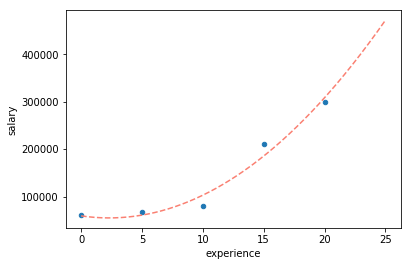

In [13]:
# Print and show dataset
df = pd.read_csv('data/othello.csv', index_col=0)
ax = df.plot.scatter(x='experience', y='salary')

# Don't worry about this. We'll get to this later.
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('line', LinearRegression(fit_intercept=True))
])

# This is a pipe, so we only need fit() and predict().
pipe.fit(
    df['experience'].values.reshape(-1,1),
    df['salary'].values.reshape(-1,1)
)

# Linspace is awesome.
linx = np.linspace(0,25, 1000).reshape(-1,1)

ax.plot(linx, pipe.predict(linx), color='salmon', linestyle='--')

In [14]:
# How does that work?
pf = PolynomialFeatures(degree=3)

# Define data.
data = np.array([
    [0], 
    [1], 
    [2]
])

# Fit transform data which can then be mapped by complex linear regressions.
pf.fit_transform(data)

array([[1., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 2., 4., 8.]])

## Other transformations

Sklearn also gives you the flexibility to put arbitrary functions in a given pipeline using a [function transformer](http://scikit-learn.org/stable/modules/preprocessing.html#function-transformer). This means that you can supply your own functions such as logs or inverse logs to arbitrarily transform arrays. Logarithmic transformations are useful for features that do not scale linearly. 

* [FunctionTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer)

In [15]:
# Create log transformer
function_transformer = FunctionTransformer(np.log10)

# Create data
X = np.arange(1,11,1).reshape(-1,1)

# Map data.
function_transformer.transform(X)

array([[0.        ],
       [0.30103   ],
       [0.47712125],
       [0.60205999],
       [0.69897   ],
       [0.77815125],
       [0.84509804],
       [0.90308999],
       [0.95424251],
       [1.        ]])

## Feature Selection

More features isn't necessarily better (see [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)). You generally want to eliminate less features, which can be done via statistical tests, model usage, or recursive feature selection (RFE).

* [SelectFromModel](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)
* [RFE](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)
* [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

Lets select our "best" features with each of these.

In [16]:
df = pd.read_csv('data/iris.csv')

X = df.iloc[:,[0,1,2,3]]
y = df.iloc[:,[4]].values.ravel()

# Create and fit base model for RFE and SelectFromModel
dtree = RandomForestClassifier()
dtree.fit(X ,y)

df.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


#### Via SelectFromModel

In [17]:
# Select features by wrapping in SelectFromModel.
model = SelectFromModel(dtree, prefit=True)
new = model.transform(X)

# Get best features out.
best_features = X.columns[model.get_support()]
bf_as_list = best_features.values.tolist()
print('Decision tree says our best features are {}.'.format(bf_as_list))

Decision tree says our best features are ['petal_length', 'petal_width'].


#### Via RFE

In [18]:
# Select features by wrapping in REFE 
model = RFE(estimator=dtree, n_features_to_select=1)
model.fit(X, y)

# Get best features out.
ranking = model.ranking_
rank_names = [X.columns[rank - 1] for rank in ranking]
print('Recursive feature elimination says our best ranking is: {} if selecting only one feature.'.format(rank_names))

Recursive feature elimination says our best ranking is: ['sepal_width', 'petal_width', 'petal_length', 'sepal_length'] if selecting only one feature.


In [19]:
### Via Kbest (requires no previous model, as it's a statistical test)
model = SelectKBest(chi2, k=2)
model.fit(X, y)

# Get best features out
best_features = X.columns[model.get_support()]
bf_as_list = best_features.values.tolist()
print('Chi squared says our best features are {}.'.format(bf_as_list))

Chi squared says our best features are ['petal_length', 'petal_width'].


## PCA

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) and [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) ([also](http://scikit-learn.org/stable/modules/lda_qda.html#lda-qda)) are often used to find useful combinations of dimensions.

* [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)
* [LinearDiscriminantAnalysis](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)

In [20]:
# Load IRIS
df = pd.read_csv('data/iris.csv')

X = df.iloc[:,[0,1,2,3]]
y = df.iloc[:, [4]].values.ravel()

# Run PCA
pca = PCA(n_components=4)
X_r = pca.fit(X).transform(X)

# Describe
print('Our explained variance ratios are {}.'.format(pca.explained_variance_ratio_))

Our explained variance ratios are [0.92461872 0.05306648 0.01710261 0.00521218].


## Text Extraction

A lot of times you will want to turn large bodies of [text into numbers](https://en.wikipedia.org/wiki/Text_mining). You can do this with sparse matrices and [tf-idf transformation](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). This will allow you to feed text data to your ML algorithms in a sane manner. See also the Natural Language Toolkit ([NLTK](https://en.wikipedia.org/wiki/Natural_Language_Toolkit)).

In [21]:
# Get CFPB data
df = pd.read_csv('data/cfpb.csv', nrows=5000, encoding='cp1252')

# Clean up. Do as I say not as I do. Always train test split.
dataset = df.dropna(subset=['Consumer complaint narrative'])
series = dataset['Consumer complaint narrative']

# Create vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Create model.
svc = SVC(kernel='linear', probability=True)

# Vectorize.
X = vectorizer.fit_transform(series.values)
y = dataset['Product']

# Fit model.
svc.fit(X, y)

# Dummy complaints
complaints = [
    'The payday loan store charges too much interest and rolled me into a new loan.',
    'Debt collectors are calling me 24 hours a day. I do not have the money.',
    'oh no how did i get here i am not good with computer'
]

# Transform
complaints_processed = vectorizer.transform(complaints)

# Predict classes.
print('Predictions:')
print(svc.predict(complaints_processed))

# Predict proba
probability = svc.predict_proba(complaints_processed)
categories  = svc.classes_
pd.DataFrame(
    data=probability,
    columns=categories,
    index=complaints
)

Predictions:
['Mortgage' 'Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports']


,Bank account or service,Checking or savings account,Consumer Loan,Credit card,Credit card or prepaid card,Credit reporting,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Money transfers,Mortgage,Other financial service,Payday loan,"Payday loan, title loan, or personal loan",Prepaid card,Student loan,Vehicle loan or lease
The payday loan store charges too much interest and rolled me into a new loan.,0.011786,0.007190,0.414327,0.012564,0.010056,0.011140,0.021064,0.024376,0.014455,0.006893,0.057930,0.007847,0.084004,0.238057,0.011181,0.053473,0.013656
Debt collectors are calling me 24 hours a day. I do not have the money.,0.032181,0.010906,0.016036,0.039808,0.013207,0.008226,0.016404,0.686461,0.102364,0.009961,0.010921,0.003574,0.010606,0.011689,0.009202,0.015197,0.003257
oh no how did i get here i am not good with computer,0.035816,0.029114,0.077976,0.055404,0.038129,0.098114,0.196750,0.263565,0.016820,0.009203,0.076486,0.013630,0.005329,0.035421,0.017847,0.020373,0.010024


# Additional Learing Resources

* ### [Sklearn Preprocessing Data](http://scikit-learn.org/stable/modules/preprocessing.html)
* ### [Sklearn Feature Selection](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection)
* ### [Sklearn Text Analysis](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
* ### [Sklearn Model Selection and Evaluation](http://scikit-learn.org/stable/model_selection.html)
* ### [Sklearn Dataset Transformations](http://scikit-learn.org/stable/data_transforms.html)

---

# Next Up: [Modeling](4_modeling.ipynb)

<br>

<img style="margin-left: 0;" src="static/svm_hyperplanes.svg" width="20%">

<br>

<div align='left'>
    Image courtesy of <a href='https://commons.wikimedia.org/wiki/File:Svm_separating_hyperplanes_(SVG).svg'>ZackWeinberg</a> under the <a href='https://creativecommons.org/licenses/by-sa/3.0/deed.en'>CC BY-SA 3.0</a>
</div>

---